# 13.1a: Extract Dead Tokens from Qwen 3 4B

**Goal:** Identify and extract dead tokens from first principles using black hole geometry.

## Method

1. Load uncentered gamma matrix
2. Find black holes (vectors with duplicates) using `torch.unique()`
3. Compute black hole centroids (both weighted and geometric)
4. Cast small sphere of radius r_net from centroid to capture ~3000 tokens
5. Histogram distances of those ~3000 tokens to reveal the void
6. Set threshold in the void to separate dead tokens from live tokens
7. Extract and save dead token IDs and embeddings with metadata

This gives us a clean, reproducible dataset for all future dead token analysis.

## Parameters

In [61]:
# Input
GAMMA_PATH = "../data/tensors/gamma_qwen3_4b_instruct_2507.safetensors"

# Output
OUTPUT_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Search parameters
INITIAL_R_NET = 1e-3  # Start very small and work outward
TARGET_TOKENS = 10000  # Want to capture ~3000 tokens in initial net

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Gamma Matrix

In [63]:
print("Loading gamma matrix...\n")

data = load_file(GAMMA_PATH)
gamma = data['gamma']  # Keep original dtype

print(f"✓ Loaded gamma matrix")
print(f"  Shape: {gamma.shape}")
print(f"  Dtype: {gamma.dtype}")

n_tokens, n_dims = gamma.shape

# Convert to float32 for calculations
gamma_f32 = gamma.to(torch.float32)

Loading gamma matrix...

✓ Loaded gamma matrix
  Shape: torch.Size([151936, 2560])
  Dtype: torch.float32


## Identify Black Holes

Black holes are vectors that have duplicates (count > 1).

In [64]:
print("\nIdentifying black holes...\n")

# Find unique vectors and their counts
unique_vectors, inverse_indices, counts = torch.unique(
    gamma_f32,
    dim=0,
    return_inverse=True,
    return_counts=True
)

# Black holes have count >= 2
black_hole_mask = counts >= 2
black_hole_vectors = unique_vectors[black_hole_mask]
black_hole_counts = counts[black_hole_mask]

# Sort by population (descending)
sorted_counts, sort_indices = torch.sort(black_hole_counts, descending=True)
sorted_black_holes = black_hole_vectors[sort_indices]

n_black_holes = len(black_hole_vectors)
total_bh_population = black_hole_counts.sum().item()

print(f"✓ Found {n_black_holes} black holes")
print(f"  Total population: {total_bh_population:,} tokens")
print(f"\nBlack hole populations:")
print(f"  {sorted_counts.tolist()}")

if n_black_holes >= 2:
    top2_pop = sorted_counts[:2].sum().item()
    print(f"\nTop 2 black holes: {sorted_counts[0].item()} + {sorted_counts[1].item()} = {top2_pop} tokens ({top2_pop/total_bh_population*100:.1f}%)")


Identifying black holes...

✓ Found 13 black holes
  Total population: 2,100 tokens

Black hole populations:
  [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

Top 2 black holes: 814 + 704 = 1518 tokens (72.3%)


## Compute Black Hole Centroids

In [65]:
print("\nComputing black hole centroids...\n")

# Geometric centroid: mean of unique black hole vectors (unweighted)
geometric_centroid = black_hole_vectors.mean(dim=0)

# Weighted centroid: mean of all black hole occurrences (weighted by population)
# Sum each vector times its count, divide by total count
weighted_sum = (black_hole_vectors * black_hole_counts.unsqueeze(1)).sum(dim=0)
weighted_centroid = weighted_sum / black_hole_counts.sum()

print(f"✓ Computed centroids")
print(f"\nGeometric centroid (unweighted mean of {n_black_holes} unique vectors):")
print(f"  Distance from origin: {torch.norm(geometric_centroid, p=2).item():.6f}")
print(f"\nWeighted centroid (population-weighted, {total_bh_population:,} tokens):")
print(f"  Distance from origin: {torch.norm(weighted_centroid, p=2).item():.6f}")
print(f"\nDistance between centroids: {torch.norm(geometric_centroid - weighted_centroid, p=2).item():.6e}")

# Use weighted centroid for analysis (better approximation of initialization point)
analysis_centroid = weighted_centroid


Computing black hole centroids...

✓ Computed centroids

Geometric centroid (unweighted mean of 13 unique vectors):
  Distance from origin: 0.370917

Weighted centroid (population-weighted, 2,100 tokens):
  Distance from origin: 0.370917

Distance between centroids: 6.097552e-06


## Cast Net to Find ~3000 Nearby Tokens

Start with small radius and expand until we capture ~3000 tokens.

In [66]:
print("\nCasting net to find nearby tokens...\n")

# Compute distances from all tokens to analysis centroid
all_distances = torch.norm(gamma_f32 - analysis_centroid, p=2, dim=1)

# Find radius that captures TARGET_TOKENS
sorted_distances, sorted_indices = torch.sort(all_distances)
r_net = sorted_distances[TARGET_TOKENS - 1].item()

# Extract tokens within net
net_mask = all_distances <= r_net
net_token_ids = torch.arange(n_tokens)[net_mask]
net_distances = all_distances[net_mask]

n_captured = len(net_token_ids)

print(f"✓ Cast net with radius r_net = {r_net:.6e}")
print(f"  Captured {n_captured:,} tokens")
print(f"\nDistance statistics (within net):")
print(f"  Min: {net_distances.min().item():.6e}")
print(f"  Max: {net_distances.max().item():.6e}")
print(f"  Mean: {net_distances.mean().item():.6e}")
print(f"  Median: {net_distances.median().item():.6e}")


Casting net to find nearby tokens...

✓ Cast net with radius r_net = 8.052777e-01
  Captured 10,000 tokens

Distance statistics (within net):
  Min: 1.671334e-05
  Max: 8.052777e-01
  Mean: 4.266257e-01
  Median: 5.090600e-01


## Visualize Distance Distribution (Within Net)

This should reveal the conspicuous void between dead and live tokens.

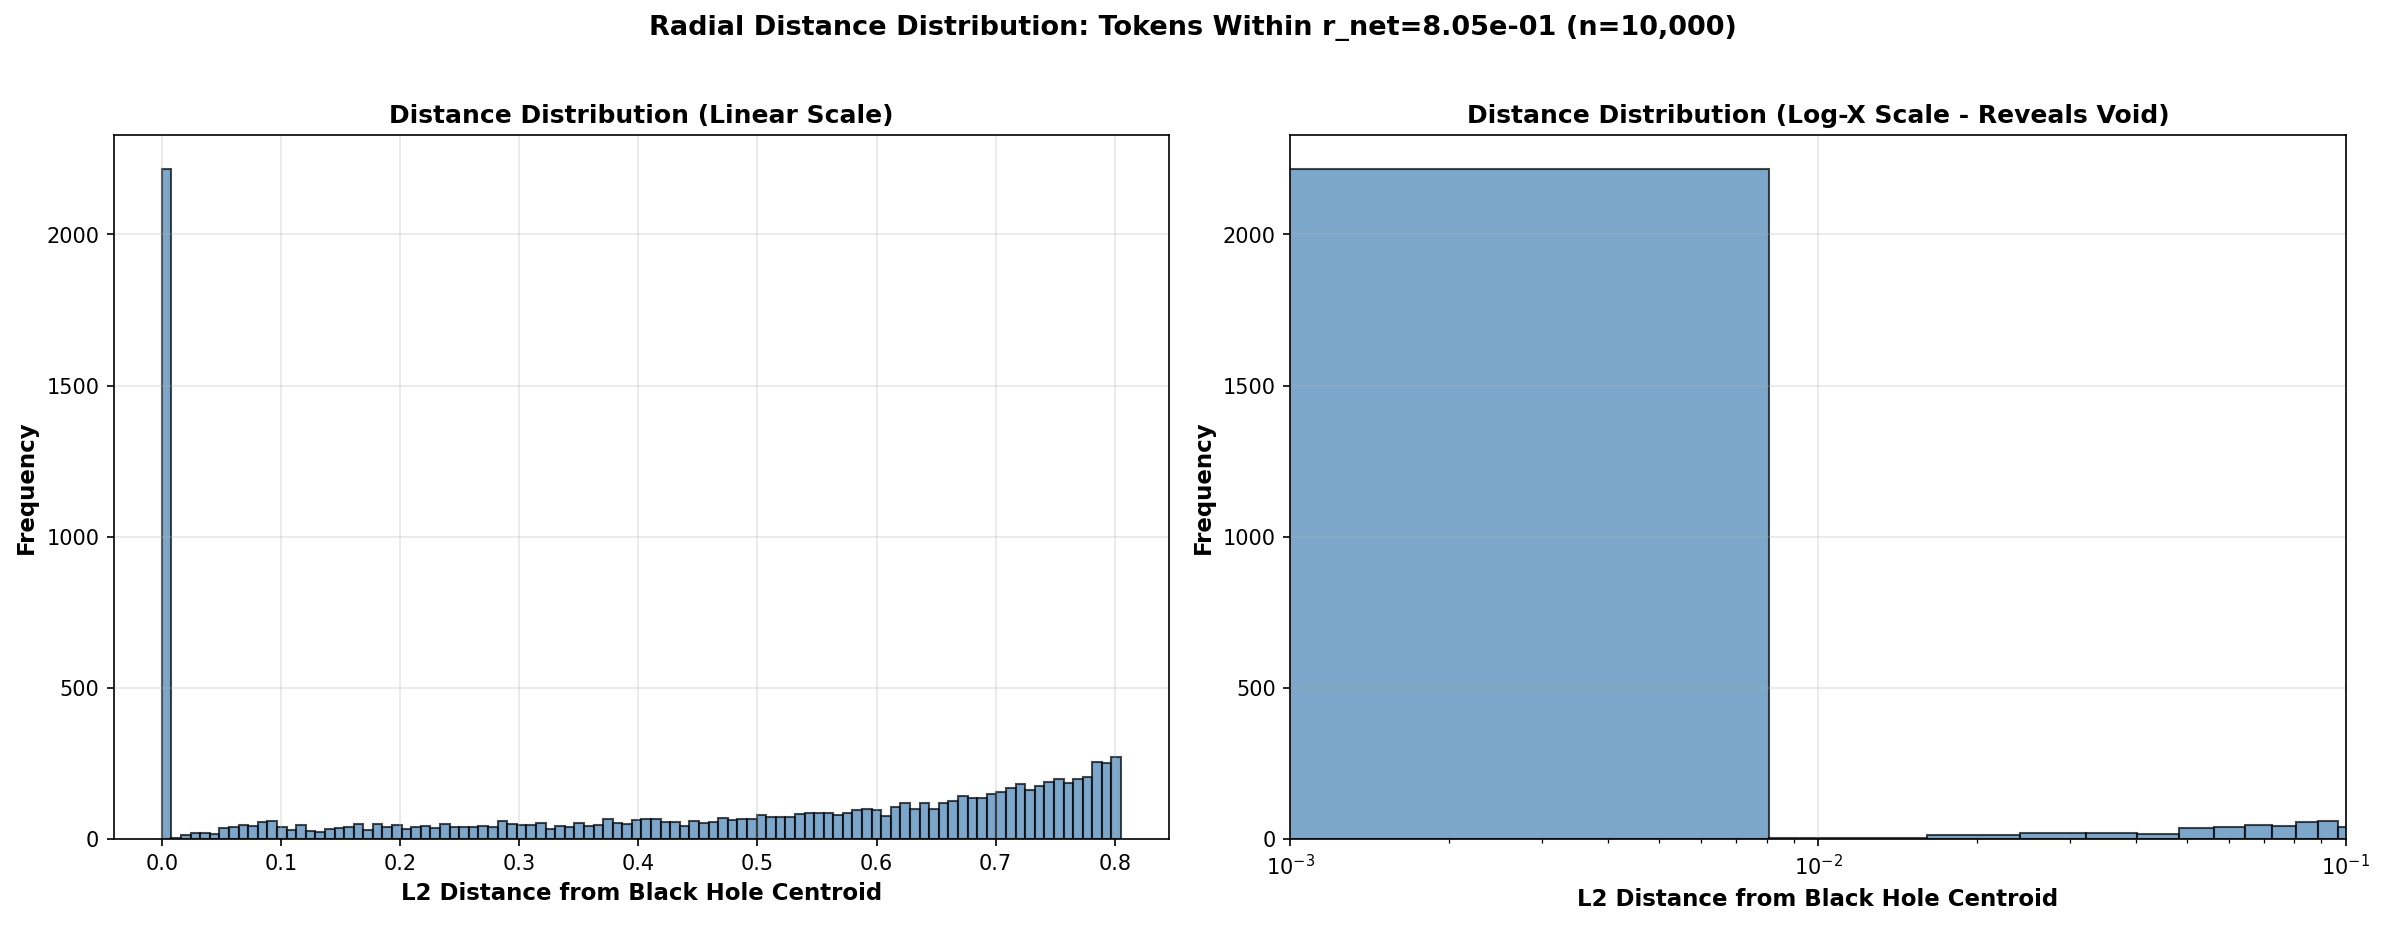


→ Look for the conspicuous void (gap) in the log-x plot


In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

net_distances_np = net_distances.cpu().numpy()

# Left: Linear scale histogram
ax = axes[0]
ax.hist(net_distances_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('L2 Distance from Black Hole Centroid', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distance Distribution (Linear Scale)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Right: Log-x scale (should reveal void as gap in distance axis)
ax = axes[1]
ax.hist(net_distances_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('L2 Distance from Black Hole Centroid', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distance Distribution (Log-X Scale - Reveals Void)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.set_xlim(left=1e-3, right=1e-1)

plt.suptitle(f'Radial Distance Distribution: Tokens Within r_net={r_net:.2e} (n={n_captured:,})',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print("\n→ Look for the conspicuous void (gap) in the log-x plot")

## Identify Void and Set Threshold

Find the largest gap in the distance distribution within the net.

In [78]:
# Sort distances within net
sorted_net_distances = torch.sort(net_distances)[0]

# Look at distances and gaps
print("\nSmallest distances within net:")
print(f"{'Rank':>6} {'Distance':>15} {'Gap to next':>15}")
print("-" * 45)

for i in range(min(20, len(sorted_net_distances))):
    dist = sorted_net_distances[i].item()
    if i < len(sorted_net_distances) - 1:
        gap = sorted_net_distances[i+1].item() - dist
        print(f"{i+1:>6} {dist:>15.6e} {gap:>15.6e}")
    else:
        print(f"{i+1:>6} {dist:>15.6e} {'---':>15}")

# Find largest gap
gaps = sorted_net_distances[1:] - sorted_net_distances[:-1]
max_gap_idx = torch.argmax(gaps).item()

threshold_lower = sorted_net_distances[max_gap_idx].item()
threshold_upper = sorted_net_distances[max_gap_idx + 1].item()
threshold = (threshold_lower + threshold_upper) / 2
gap_size = threshold_upper - threshold_lower

print(f"\n{'='*45}")
print(f"LARGEST GAP (THE VOID)")
print(f"{'='*45}")
print(f"Between ranks {max_gap_idx+1} and {max_gap_idx+2}")
print(f"  Distance at rank {max_gap_idx+1}: {threshold_lower:.6e}")
print(f"  Distance at rank {max_gap_idx+2}: {threshold_upper:.6e}")
print(f"  Gap size: {gap_size:.6e}")
print(f"\n→ Setting threshold: {threshold:.6e}")
print(f"{'='*45}")


Smallest distances within net:
  Rank        Distance     Gap to next
---------------------------------------------
     1    1.671334e-05    0.000000e+00
     2    1.671334e-05    0.000000e+00
     3    1.671334e-05    0.000000e+00
     4    1.671334e-05    0.000000e+00
     5    1.671334e-05    1.818989e-12
     6    1.671335e-05    0.000000e+00
     7    1.671335e-05    0.000000e+00
     8    1.671335e-05    0.000000e+00
     9    1.671335e-05    0.000000e+00
    10    1.671335e-05    0.000000e+00
    11    1.671335e-05    0.000000e+00
    12    1.671335e-05    0.000000e+00
    13    1.671335e-05    0.000000e+00
    14    1.671335e-05    0.000000e+00
    15    1.671335e-05    0.000000e+00
    16    1.671335e-05    0.000000e+00
    17    1.671335e-05    0.000000e+00
    18    1.671335e-05    0.000000e+00
    19    1.671335e-05    0.000000e+00
    20    1.671335e-05    0.000000e+00

LARGEST GAP (THE VOID)
Between ranks 2221 and 2222
  Distance at rank 2221: 9.574379e-03
  Distance at

## Extract Dead Tokens

In [79]:
print("\nExtracting dead tokens...\n")

# Dead tokens are those within threshold of black hole centroid
dead_mask = all_distances < threshold
dead_token_ids = torch.arange(n_tokens)[dead_mask]
dead_embeddings_bfloat16 = gamma[dead_mask].to(torch.bfloat16)
dead_embeddings_float32 = gamma_f32[dead_mask]

n_dead = len(dead_token_ids)

print(f"✓ Extracted {n_dead:,} dead tokens")

# Verify structure
dead_unique, dead_inverse, dead_counts = torch.unique(
    dead_embeddings_float32, dim=0, return_inverse=True, return_counts=True
)

n_unique = len(dead_unique)
n_singletons = (dead_counts == 1).sum().item()
n_dead_black_holes = (dead_counts >= 2).sum().item()

print(f"\nStructure:")
print(f"  Unique vectors: {n_unique}")
print(f"  Singletons (count=1): {n_singletons}")
print(f"  Black holes (count≥2): {n_dead_black_holes}")

# Show black hole populations
dead_bh_counts = dead_counts[dead_counts >= 2]
sorted_dead_bh_counts = torch.sort(dead_bh_counts, descending=True)[0]

print(f"\nBlack hole populations in dead tokens:")
print(f"  {sorted_dead_bh_counts.tolist()}")

if n_dead_black_holes >= 2:
    top2_fraction = sorted_dead_bh_counts[:2].sum().item() / n_dead
    print(f"\nTop 2 black holes contain: {top2_fraction*100:.1f}% of dead tokens")


Extracting dead tokens...

✓ Extracted 2,221 dead tokens

Structure:
  Unique vectors: 134
  Singletons (count=1): 121
  Black holes (count≥2): 13

Black hole populations in dead tokens:
  [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

Top 2 black holes contain: 68.3% of dead tokens


## Save Data

In [80]:
print("\nSaving data...\n")

# Prepare tensors for saving
save_dict = {
    'dead_token_ids': dead_token_ids.to(torch.int64),
    'dead_embeddings_bfloat16': dead_embeddings_bfloat16,
    'dead_embeddings_float32': dead_embeddings_float32,
    'geometric_centroid': geometric_centroid,
    'weighted_centroid': weighted_centroid,
    'threshold_radius': torch.tensor(threshold, dtype=torch.float32),
    'num_dead_tokens': torch.tensor(n_dead, dtype=torch.int64),
    'num_unique_vectors': torch.tensor(n_unique, dtype=torch.int64),
    'num_singletons': torch.tensor(n_singletons, dtype=torch.int64),
    'num_black_holes': torch.tensor(n_dead_black_holes, dtype=torch.int64),
}

save_file(save_dict, OUTPUT_PATH)

print(f"✓ Saved to {OUTPUT_PATH}")
print(f"\nSaved tensors:")
for key in save_dict.keys():
    tensor = save_dict[key]
    if tensor.ndim == 0:
        print(f"  {key}: scalar = {tensor.item()}")
    else:
        print(f"  {key}: shape={tensor.shape}, dtype={tensor.dtype}")


Saving data...

✓ Saved to ../data/tensors/13.1a_dead_tokens.safetensors

Saved tensors:
  dead_token_ids: shape=torch.Size([2221]), dtype=torch.int64
  dead_embeddings_bfloat16: shape=torch.Size([2221, 2560]), dtype=torch.bfloat16
  dead_embeddings_float32: shape=torch.Size([2221, 2560]), dtype=torch.float32
  geometric_centroid: shape=torch.Size([2560]), dtype=torch.float32
  weighted_centroid: shape=torch.Size([2560]), dtype=torch.float32
  threshold_radius: scalar = 0.012141738086938858
  num_dead_tokens: scalar = 2221
  num_unique_vectors: scalar = 134
  num_singletons: scalar = 121
  num_black_holes: scalar = 13


## Summary

In [81]:
print(f"\n{'='*80}")
print(f"DEAD TOKEN EXTRACTION COMPLETE")
print(f"{'='*80}")
print(f"\nMethod:")
print(f"  1. Identified {n_black_holes} black holes (vectors with duplicates)")
print(f"  2. Computed weighted centroid from {total_bh_population:,} black hole tokens")
print(f"  3. Cast net with radius {r_net:.6e} to capture {n_captured:,} tokens")
print(f"  4. Found void at distance {threshold:.6e} (gap size: {gap_size:.6e})")
print(f"  5. Extracted {n_dead:,} dead tokens below threshold")
print(f"\nStructure:")
print(f"  {n_unique} unique vectors ({n_singletons} singletons + {n_dead_black_holes} black holes)")
print(f"  Largest black hole: {sorted_dead_bh_counts[0].item()} tokens")
print(f"\nSaved to: {OUTPUT_PATH}")
print(f"\nNext steps:")
print(f"  - Load dead_embeddings_bfloat16 for bit-level analysis")
print(f"  - Load dead_embeddings_float32 for distance calculations")
print(f"  - Use centroids to study initialization geometry")
print(f"\n{'='*80}")


DEAD TOKEN EXTRACTION COMPLETE

Method:
  1. Identified 13 black holes (vectors with duplicates)
  2. Computed weighted centroid from 2,100 black hole tokens
  3. Cast net with radius 8.052777e-01 to capture 10,000 tokens
  4. Found void at distance 1.214174e-02 (gap size: 5.134718e-03)
  5. Extracted 2,221 dead tokens below threshold

Structure:
  134 unique vectors (121 singletons + 13 black holes)
  Largest black hole: 814 tokens

Saved to: ../data/tensors/13.1a_dead_tokens.safetensors

Next steps:
  - Load dead_embeddings_bfloat16 for bit-level analysis
  - Load dead_embeddings_float32 for distance calculations
  - Use centroids to study initialization geometry

